In [1]:
import os

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import PopulationBasedTraining
from attention_pytorch import focal_loss, LSTMWithAttention
import pandas as pd
import numpy as np

import math as math
import aiutils.ai_backtester as bt
import matplotlib.pyplot as plt

from sortino import compute_sortino

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

pd.options.display.width=None

np.set_printoptions(suppress=True)


# Importation des jeux de données et céation des features

In [2]:
from preprocess import *

aiutils-0.58/aiutils/features_manager.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
aiutils-0.58/aiutils/features_manager.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
aiutils-0.58/aiutils/features_manager.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c

                        bars     days   weeks  months  years
Before Date Filtering  73863  4281.38  611.62  138.11  11.73
After Date Filtering   73863  4281.38  611.62  138.11  11.73
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(51693, 16, 12) (11077, 16, 12) (11078, 16, 12) (73848,)
2010-01-07T15:00:00.000000000 2021-09-27T09:00:00.000000000
After Time Filtering
(10652, 16, 12) (2270, 16, 12) (2270, 16, 12) (15192,)
2010-01-07T15:00:00.000000000 2021-09-24T16:00:00.000000000
val start : 2018-03-27T12:00:00.000000000
test start : 2019-12-26T12:00:00.000000000
                       bars    days  weeks  months  years
Before Date Filtering  8208  470.54  67.22   15.18   1.29
After Date Filtering   8208  470.54  67.22   15.18   1.29
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(8193, 16, 12) (0, 16, 12) (0, 16, 12) (8193,)
2021-09-28T01:00:00.000000000 2023-01-10T23:00:00.000000000
After Time Filtering
(1680, 16, 12) (0, 16, 12) (0, 16, 12) (1680,)
2021-09-28T1

In [3]:
def get_data_loaders(X_train, y_train, X_val, y_val, batch_size=64):

    #convertion au format pytorch des données fourines par la fonction préprocess LUSIS, initialement au format numpy

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

   
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [4]:
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val)

# Création de la fonction d'entrainement

In [5]:
lytrain = len(y_train)
lyval = len(y_val)

def train_attention(config):

    ######## création du modèle ########

    step = 1
    model = LSTMWithAttention(len(features),6,12,32, softmax = True)
    optimizer = optim.SGD(
        model.parameters(),
        lr=config.get("lr", 0.01),
        momentum=config.get("momentum", 0.9),
    )
    criterion = focal_loss(alpha=config.get("alpha", 0.25), gamma=config.get("gamma", 2.0))

    ######## chargement du checkpoint s'il existe ########

    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        for param_group in optimizer.param_groups:
            param_group["lr"] = config.get("lr", 0.01)
            param_group["momentum"] = config.get("momentum", 0.9)

        step = checkpoint_dict["step"] + 1

    ######## boucle d'entrainement ########

    while True:

        ### entraiement ###
        model.train()
        for inputs, labels in ray.get(train_loader):
            optimizer.zero_grad()
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()


        ### evaluation ###
        with torch.no_grad():
            model.eval()
            val_inputs = torch.tensor(ray.get(X_val), dtype=torch.float32) 
            val_outputs = model(val_inputs).detach().cpu().numpy()
        sortino = compute_sortino(ray.get(df),
                        val_outputs,
                        ray.get(y_datetime)[lytrain : lytrain+lyval],
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)
        metrics = {"loss": loss.item(), "lr": config["lr"], "sortino":sortino}

        ### rendre compte au scheduler et sauvegarder si nécessaire ###
        if step % config["checkpoint_interval"] == 0:
            tmpdir = "C:/ray_checkpoints"
            torch.save({
                "step": step,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, tmpdir + "/checkpoint.pt")
            train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
        else:
            train.report(metrics)

        step += 1

# Population Based Training

ou autre en changeant de scheduler

In [6]:
perturbation_interval = 5

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=5,
    metric="sortino",
    mode="max",
    hyperparam_mutations={
        "lr": tune.loguniform(0.0001, 1),
        "momentum": tune.choice([0.8, 0.9, 0.99]),
        "alpha": tune.uniform(0.2, 0.3),
        "gamma": tune.uniform(1.5, 2.5),
    },
)

In [7]:
######## initialisation de ray ########
if ray.is_initialized():
    ray.shutdown()
ray.init()

# ray.put donne l'equivalent de pointeurs, pour éviter de copier les données à chaque fois
df = ray.put(df) if not isinstance(train_loader, ray.ObjectRef) else train_loader
train_loader = ray.put(train_loader) if not isinstance(train_loader, ray.ObjectRef) else train_loader
val_loader = ray.put(val_loader) if not isinstance(val_loader, ray.ObjectRef) else val_loader
y_datetime = ray.put(y_datetime) if not isinstance(y_datetime, ray.ObjectRef) else y_datetime
X_val = ray.put(X_val) if not isinstance(X_val, ray.ObjectRef) else X_val

######## initialisation du tuner/scheduler ########
tuner = tune.Tuner(
    train_attention,
    run_config=train.RunConfig(
        name="pbt_test",
        # Stop when we've reached a threshold accuracy, or a maximum
        # training_iteration, whichever comes first
        stop={"sortino": 3, "training_iteration": 100},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="loss",
            num_to_keep=16,
        ),
        storage_path="/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        reuse_actors=False,
        num_samples=16,
    ),
    param_space={
        "lr": tune.loguniform(0.0001, 1),
        "momentum": tune.choice([0.8, 0.9, 0.99]),
        "alpha": tune.uniform(0.1, 2),
        "gamma": tune.uniform(1, 5),
        "checkpoint_interval": perturbation_interval,
    },
)

######## lancement du tuner (très très long) ########
results_grid = tuner.fit()

2024-04-26 02:01:11,349	WARNING util.py:202 -- The `on_step_begin` operation took 34.268 s, which may be a performance bottleneck.
2024-04-26 02:01:48,286	WARNING util.py:202 -- The `on_step_begin` operation took 16.792 s, which may be a performance bottleneck.
2024-04-26 02:03:06,560	WARNING util.py:202 -- The `on_step_begin` operation took 38.009 s, which may be a performance bottleneck.
2024-04-26 02:03:39,480	WARNING util.py:202 -- The `on_step_begin` operation took 2.837 s, which may be a performance bottleneck.
2024-04-26 02:04:04,348	WARNING util.py:202 -- The `on_step_begin` operation took 4.610 s, which may be a performance bottleneck.
2024-04-26 02:04:49,287	WARNING util.py:202 -- The `on_step_begin` operation took 14.740 s, which may be a performance bottleneck.
2024-04-26 02:05:01,254	WARNING util.py:202 -- The `on_step_begin` operation took 1.875 s, which may be a performance bottleneck.
2024-04-26 02:05:31,010	WARNING util.py:202 -- The `on_step_begin` operation took 9.49

(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

2024-04-26 03:04:48,929	WARNING util.py:202 -- The `on_step_begin` operation took 5.900 s, which may be a performance bottleneck.


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=17500) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss


2024-04-26 03:05:31,135	WARNING util.py:202 -- The `on_step_begin` operation took 11.889 s, which may be a performance bottleneck.


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=19196) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=7004) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000002)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=13324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=21628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=7640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss


2024-04-26 03:06:37,718	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00008 (score = 0.889126)

2024-04-26 03:06:37,720	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00008:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (resample) --> 0.99
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (resample) --> 2.2022352874732767

(train_attention pid=1688) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000002)


(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(train_attention pid=15520) NaN detected in loss
(train_attention pid=15520) NaN detected in pred
(train_attention pid=15520) NaN detected in log_pred_soft
(train_attention pid=15520) NaN detected in loss_tmp
(tra

(train_attention pid=11416) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)
(train_attention pid=11368) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000002)
(train_attention pid=15520) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)
(train_attention pid=10264) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000002) [repeated 2x across cluster

(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=16828) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=21672) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=7992) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=5232) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=22148) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

2024-04-26 03:10:21,162	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00011 (score = -1.226429)

2024-04-26 03:10:21,163	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00011:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (resample) --> 0.24461979441521636
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016



(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss


(train_attention pid=7968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=11492) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=21248) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000002)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

2024-04-26 03:11:39,417	WARNING util.py:202 -- The `on_step_begin` operation took 8.137 s, which may be a performance bottleneck.


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=1688) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=4332) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=11368) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=10264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000003) [repeated 2x across cluster]


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=8712) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=4020) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(train_attention pid=22240) NaN detected in loss
(train_attention pid=22240) NaN detected in pred
(train_attention pid=22240) NaN detected in log_pred_soft
(train_attention pid=22240) NaN detected in loss_tmp
(tra

(train_attention pid=22240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=548) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=16828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)
2024-04-26 03:16:53,698	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 03:16:53,701	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparame

(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=79

2024-04-26 03:21:58,175	WARNING util.py:202 -- The `on_step_begin` operation took 31.510 s, which may be a performance bottleneck.


(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=79

2024-04-26 03:22:41,281	WARNING util.py:202 -- The `on_step_begin` operation took 22.910 s, which may be a performance bottleneck.


(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=79

(train_attention pid=4332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=79

(train_attention pid=16152) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=7932) NaN detected in loss
(train_attention pid=7932) NaN detected in pred
(train_attention pid=7932) NaN detected in log_pred_soft
(train_attention pid=7932) NaN detected in loss_tmp
(train_attention pid=79

2024-04-26 03:25:10,760	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 03:25:10,763	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (resample) --> 2.038617565318675

(train_attention pid=8712) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=7932) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=6392) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=6392) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=6392) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=6392) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=3928) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=7932

(train_attention pid=3212) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=6392) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=6392) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=6392) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=6392) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=3928) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=6392

(train_attention pid=11244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=19252) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=3928) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=3928) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 14x across cluster]


(train_attention pid=6392) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 03:26:23,721	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 03:26:23,780	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 1.2) --> 2.156128200045812
gamma : 4.777359966438171 --- (* 0.8) --> 3.821887973150537



(train_attention pid=3928) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=3928) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=3928) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=3928) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=1612) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=7932) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 8x across cluster]


2024-04-26 03:26:43,137	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 03:26:43,154	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.44609801227094664 --- (resample) --> 0.4943129151812841
momentum : 0.99 --- (* 1.2) --> 1.188
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (* 0.8) --> 3.821887973150537



(train_attention pid=7932) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=7932) NaN detect

(train_attention pid=16580) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=3928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003) [repeated 2x across cluster]


(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=5416) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=3672) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=17476) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=7932) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=20904) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=14648) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=14748) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=7932) NaN detected in pred [repeated 6x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 6x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 6x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 6x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=11816) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932

(train_attention pid=18560) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=7932) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=7932

(train_attention pid=7932) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 03:29:41,812	WARNING util.py:202 -- The `on_step_begin` operation took 3.393 s, which may be a performance bottleneck.
(train_attention pid=2316) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=8820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=3952) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_0

(train_attention pid=17476) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 7x across cluster]


2024-04-26 03:34:57,355	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 03:34:57,357	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 1.2) --> 2.156128200045812
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805

(train_attention pid=19252) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=5104) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoin

(train_attention pid=17476) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=17476) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=18340) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=17476) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17476) NaN detected in loss [repeated 10x across cluster]
(train_attent

2024-04-26 03:36:03,362	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 03:36:03,365	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011

(train_attention pid=17476) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)
2024-04-26 03:36:04,159	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 03:36:04,161	INFO pbt.py:905 -- 

[Pop

(train_attention pid=13748) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 2x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1374

(train_attention pid=12304) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=2316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=11700) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=3952) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 5x across cluster]


(train_attention pid=15092) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=13256) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1374

(train_attention pid=15208) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1374

2024-04-26 03:44:45,517	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 03:44:45,520	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016

(train_attention pid=18340) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention 

(train_attention pid=14028) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)
(train_attention pid=5104) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=13748) NaN detected in pred [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 5x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 8x across cluster]


2024-04-26 03:45:34,363	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 03:45:34,366	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (resample) --> 0.7613688242577533
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (resample) --> 0.2699103948360894
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011

(train_attention pid=3424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=19980) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-0

(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1374

(train_attention pid=21984) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=13560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=13748) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 10x across cluster]
(train_attention 

2024-04-26 03:46:31,381	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 03:46:31,385	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (resample) --> 0.9
alpha : 1.796773500038177 --- (* 1.2) --> 2.156128200045812
gamma : 4.777359966438171 --- (* 0.8) --> 3.821887973150537

(train_attention pid=7400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=8228) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint

(train_attention pid=13748) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=2108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 03:46:43,393	WARNING util.py:202 -- The `on_step_begin` operation took 3.937 s, which may be a performance bottleneck.
2024-04-26 03:46:43,414	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 03:46:43,416	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (resample) --> 0.20413164515312965
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644



(train_attention pid=13748) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=14220) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)
2024-04-26 03:46:55,764	WARNING util.py:202 -- The `on_step_begin` operation took 2.061 s, which may be a performance bottleneck.


(train_attention pid=13748) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=13748) NaN detected in loss [repeated 7x across cluster]


(train_attention pid=13748) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)
(train_attention pid=13272) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 2x across cluster]


(train_attention pid=12304) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)
(train_attention pid=16768) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005) [repeated 2x across cluster]


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=13456) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=2272) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1676

(train_attention pid=11700) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 2x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=7280) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=15092) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1676

(train_attention pid=7940) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1676

2024-04-26 03:50:39,560	WARNING util.py:202 -- The `on_step_begin` operation took 21.078 s, which may be a performance bottleneck.


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1676

2024-04-26 03:51:16,432	WARNING util.py:202 -- The `on_step_begin` operation took 6.436 s, which may be a performance bottleneck.


(train_attention pid=16768) NaN detected in pred [repeated 4x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 4x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 4x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 4x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1676

2024-04-26 03:52:34,997	WARNING util.py:202 -- The `on_step_begin` operation took 37.519 s, which may be a performance bottleneck.


(train_attention pid=16768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=15208) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=1676

(train_attention pid=10668) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 19x across cluster]
(train_attention 

(train_attention pid=14028) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)
2024-04-26 03:54:19,022	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 03:54:19,024	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 1.9611613333931466 --- (resample) --> 2.2911939377004438



(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=15232) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)
(train_attention pid=19980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=16768) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=8228) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)
(train_attention pid=9480) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=10668) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=6080) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=16768) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 9x across cluster]


2024-04-26 03:55:45,878	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 03:55:45,880	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (resample) --> 0.09613887067455533
momentum : 0.9 --- (resample) --> 0.99
alpha : 0.6777545982523104 --- (* 0.8) --> 0.5422036786018484
gamma : 1.2265752078447514 --- (resample) --> 2.0375118237365566

(train_attention pid=21984) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=10668) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attent

(train_attention pid=14692) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=13456) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=10668) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=16768) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=16768) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=16768) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=16768) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 15x across cluster]


(train_attention pid=13040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 03:57:02,234	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 03:57:02,278	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (resample) --> 0.22369430037269675
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016



(train_attention pid=10668) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=13272) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 8x across cluster]


2024-04-26 03:57:15,136	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 03:57:15,154	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (* 0.8) --> 0.9504
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 1.2) --> 6.879398351670965

(train_attention pid=16768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=10668) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=2272) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=17704) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(train_attention pid=10668) NaN detected in loss


(train_attention pid=14596) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(train_attention pid=10668) NaN detected in loss
(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(train_attention pid=10668) NaN detected in loss
(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(train_attention pid=10668) NaN detected in loss
(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(train_attention pid=10668) NaN detected in loss
(train_attention pid=10668) NaN detected in pred
(train_attention pid=10668) NaN detected in log_pred_soft
(train_attention pid=10668) NaN detected in loss_tmp
(tra

(train_attention pid=8220) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=14596) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=22052) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=2408) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=7940) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attent

(train_attention pid=7280) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=10668) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 12x across cluster]


(train_attention pid=21020) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=17272) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 19x across cluster]
(train_attent

2024-04-26 04:01:03,508	WARNING util.py:202 -- The `on_step_begin` operation took 27.571 s, which may be a performance bottleneck.


(train_attention pid=10668) NaN detected in pred [repeated 3x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 3x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 3x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 3x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 20x across cluster]
(train_attention 

2024-04-26 04:01:26,458	WARNING util.py:202 -- The `on_step_begin` operation took 2.618 s, which may be a performance bottleneck.


(train_attention pid=10668) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 18x across cluster]
(train_attent

2024-04-26 04:02:05,333	WARNING util.py:202 -- The `on_step_begin` operation took 18.592 s, which may be a performance bottleneck.


(train_attention pid=10668) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=10668) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=10668) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=10668) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=10668) NaN detected in loss [repeated 14x across cluster]
(train_attent

(train_attention pid=10668) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=14596) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=22072) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention 

2024-04-26 04:03:57,719	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:03:57,721	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.9180321620616327 --- (resample) --> 0.005571455153370878
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (resample) --> 0.2798024513521925
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011

(train_attention pid=9480) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=10740) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 4x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 4x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 4x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 4x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=12900) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=6080) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=8816) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000006)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=14692) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14596) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1459

(train_attention pid=17704) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)2024-04-26 04:06:29,450	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)


2024-04-26 04:06:29,452	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (resample) --> 0.0017125239715159654
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=5232) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/c

(train_attention pid=19000) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 8x across cluster]


(train_attention pid=21020) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=4884) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=21560) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=17272) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=17844) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

2024-04-26 04:13:01,232	WARNING util.py:202 -- The `on_step_begin` operation took 3.740 s, which may be a performance bottleneck.


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=22072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=13928) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=10740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=3344) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


2024-04-26 04:14:29,387	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:14:29,390	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.44609801227094664 --- (* 0.8) --> 0.35687840981675734
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805

(train_attention pid=12900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=2444) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention 

(train_attention pid=8816) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=16052) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)


(train_attention pid=19000) NaN detected in pred [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 6x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=5232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


2024-04-26 04:16:10,806	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 04:16:10,808	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (resample) --> 0.45008529260309493
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 1.9611613333931466 --- (* 0.8) --> 1.5689290667145173

(train_attention pid=19404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=3300) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=20396) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=19000) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=19000) 
(train_attention pid=19000) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 11x across 

2024-04-26 04:17:11,531	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 04:17:11,535	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.44609801227094664 --- (resample) --> 0.04312644030845688
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805

(train_attention pid=17096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=19000) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 7x across cluster]


(train_attention pid=20904) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 04:17:17,061	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 04:17:17,078	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (* 0.8) --> 0.5422036786018484
gamma : 1.2265752078447514 --- (resample) --> 2.153631448115222



(train_attention pid=19000) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=19000) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=19000) NaN detected in loss [repeated 7x across cluster]


(train_attention pid=19000) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)
(train_attention pid=12644) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000007)
(train_attention pid=4884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)
(train_attention pid=11492) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000007)
(train_attention pid=10836)

(train_attention pid=21560) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 2x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=3344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=13900) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=2444) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=16976) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]


2024-04-26 04:25:04,199	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:25:04,201	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (resample) --> 0.23584577833796985
gamma : 5.732831959725805 --- (resample) --> 2.0229415672031044

(train_attention pid=16052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 4x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 4x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 4x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 4x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=9964) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=3300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]


2024-04-26 04:26:01,923	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 04:26:01,926	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (resample) --> 0.8
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (resample) --> 2.1218150935643143

(train_attention pid=20396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=12644) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)
(train_attention pid=15364) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=21560) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 18x across cluster]
(train_attention 

(train_attention pid=16616) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009) [repeated 2x across cluster]


(train_attention pid=15364) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 9x across cluster]


2024-04-26 04:27:05,629	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 04:27:05,631	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=11492) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=21560) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 14x across cluster]
(train_attent

2024-04-26 04:27:38,328	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

(train_attention pid=10836) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 04:27:38,342	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.44609801227094664 --- (* 0.8) --> 0.35687840981675734
momentum : 0.99 --- (resample) --> 0.9
alpha : 1.796773500038177 --- (resample) --> 0.26493470078188514
gamma : 4.777359966438171 --- (* 0.8) --> 3.821887973150537



(train_attention pid=15364) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 14x across cluster]
(train_attent

(train_attention pid=17448) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)
(train_attention pid=20880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 22x across cluster]


(train_attention pid=20780) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000008)
(train_attention pid=9744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=21560) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 21x across cluster]


(train_attention pid=8936) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=21560) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 30x across cluster]
(train_attent

(train_attention pid=17168) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 29x across cluster]
(train_attent

(train_attention pid=20860) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=20780) NaN detected in pred [repeated 25x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 25x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 25x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 25x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 26x across cluster]
(train_attent

(train_attention pid=17468) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=21560) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 19x across cluster]
(train_attent

2024-04-26 04:31:44,448	WARNING util.py:202 -- The `on_step_begin` operation took 5.190 s, which may be a performance bottleneck.


(train_attention pid=15364) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=21560) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21560) NaN detected in loss [repeated 19x across cluster]
(train_attent

2024-04-26 04:32:11,609	WARNING util.py:202 -- The `on_step_begin` operation took 6.952 s, which may be a performance bottleneck.


(train_attention pid=20780) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 13x across cluster]


(train_attention pid=21560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 16x across cluster]
(train_attent

2024-04-26 04:32:41,121	WARNING util.py:202 -- The `on_step_begin` operation took 8.322 s, which may be a performance bottleneck.


(train_attention pid=20780) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 15x across cluster]


2024-04-26 04:32:53,492	WARNING util.py:202 -- The `on_step_begin` operation took 2.132 s, which may be a performance bottleneck.


(train_attention pid=20780) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 14x across cluster]


(train_attention pid=13900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=22344) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=20780) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=13036) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=16976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=17728) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)
(train_attention pid=9964) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=20780) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15364) 
(train_attention pid=20780) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 19x 

(train_attention pid=2164) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=15364) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 17x across cluster]
(train_attent

2024-04-26 04:35:26,335	WARNING util.py:202 -- The `on_step_begin` operation took 1.935 s, which may be a performance bottleneck.


(train_attention pid=15364) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=15364) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15364) NaN detected in loss [repeated 9x across cluster]
(train_attention 

2024-04-26 04:35:58,087	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 04:35:58,090	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (resample) --> 0.00012089401195743141
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (resample) --> 2.1902713903562363

(train_attention pid=6296) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)
2024-04-26 04:35:58,950	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:35:58,952	INFO pbt.py:905

(train_attention pid=20780) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=2432) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)
(train_attention pid=15364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=20780) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 12x across cluster]


(train_attention pid=16616) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)
(train_attention pid=16976) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=20780) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 15x across cluster]
(train_attent

2024-04-26 04:36:58,538	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 04:36:58,540	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.44609801227094664 --- (* 0.8) --> 0.35687840981675734
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (resample) --> 0.26461570383780486
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805

(train_attention pid=8936) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=20780) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=10720) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000008)


(train_attention pid=16976) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=20780) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 17x across cluster]


(train_attention pid=17448) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=20780) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=20780) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=20780) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=17168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 8x across cluster]


2024-04-26 04:37:39,537	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 04:37:39,539	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 1.9611613333931466 --- (resample) --> 2.059574997089727

(train_attention pid=20780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=16976) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1697

(train_attention pid=11060) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 4x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 4x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 4x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 4x across cluster]


(train_attention pid=22248) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=17468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=14524) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=7672) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1697

(train_attention pid=8660) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1697

(train_attention pid=22344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 7x across cluster]


(train_attention pid=13036) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=21388) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=22104) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=2164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 3x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 3x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 3x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 3x across cluster]


(train_attention pid=17728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)
(train_attention pid=16864) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=

(train_attention pid=8736) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=

2024-04-26 04:44:57,931	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 04:44:57,934	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (resample) --> 0.8
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=2432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=16976) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=16616) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=16976) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16976) NaN detected in loss [repeated 10x across cluster]


2024-04-26 04:45:37,244	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:45:37,246	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (resample) --> 0.21416699089686275
gamma : 1.9611613333931466 --- (resample) --> 2.29382219769745

(train_attention pid=10720) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=16976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-2

(train_attention pid=15384) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=7672) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 10x across cluster]


2024-04-26 04:47:33,662	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 04:47:33,666	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (resample) --> 0.266206136749267
gamma : 5.732831959725805 --- (* 1.2) --> 6.879398351670965

(train_attention pid=22248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=15384) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=14524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=1538

(train_attention pid=2108) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=8660) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000011)
(train_attention pid=14068) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=14068) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=11704) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000009)


(train_attention pid=14068) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=10476) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=14068) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15384) 
(train_attention pid=14068) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 19x 

(train_attention pid=21388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=14068) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=18836) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attent

(train_attention pid=22104) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 29x across cluster]
(train_attent

(train_attention pid=8736) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011) [repeated 2x across cluster]


(train_attention pid=15384) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 9x across cluster]
(train_attention 

(train_attention pid=11484) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 27x across cluster]


(train_attention pid=2156) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=18836) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attent

(train_attention pid=21780) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 30x across cluster]
(train_attent

(train_attention pid=16616) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=15384) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 31x across cluster]
(train_attent

(train_attention pid=21392) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=15384) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 9x across cluster]


2024-04-26 04:55:10,695	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 04:55:10,698	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (resample) --> 0.99
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=9480) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=14068) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=15384) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=15384) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=15384) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=15384) NaN detected in loss [repeated 28x across cluster]


2024-04-26 04:55:18,481	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 04:55:18,483	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (resample) --> 0.24825844931634286
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=7184) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=14068) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=18836) 
(train_attention pid=14068) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=14068) 
(train_attention pid=14068) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14068) NaN de

2024-04-26 04:55:35,438	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 04:55:35,440	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=15384) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=6944) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoi

(train_attention pid=18836) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=19808) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=14068) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 30x across cluster]


(train_attention pid=8980) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=14068) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=14068) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=14068) NaN detected in loss [repeated 28x across cluster]
(train_attent

2024-04-26 04:56:46,026	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 04:56:46,028	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (resample) --> 0.00805212376329002
momentum : 1.188 --- (resample) --> 0.99
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=14068) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=19808) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=18836) 
(train_attention pid=18836) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 15x acro

(train_attention pid=10384) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=18836) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=11704) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=18836) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 12x across cluster]


(train_attention pid=2108) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=18836) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=16508) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000010)
(train_attention pid=10476) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 24x across cluster]
(train_attent

(train_attention pid=11060) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 28x across cluster]
(train_attent

(train_attention pid=19492) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=18836) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=18836) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=18836) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=18836) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=20360) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=19808) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=11484) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 18x across cluster]
(train_attent

(train_attention pid=11012) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=21780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=16508) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 18x across cluster]
(train_attent

(train_attention pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=19808) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 16x across cluster]
(train_attent

(train_attention pid=21392) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=19808) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=10220) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=19808) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 21x across cluster]
(train_attent

(train_attention pid=732) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=19808) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19808) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19808) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19808) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 10x across cluster]
(train_attent

(train_attention pid=9708) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)
2024-04-26 05:04:30,906	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 05:04:30,908	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (resample) --> 0.21150674508219217
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=19808) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46

(train_attention pid=16508) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=16508) 
(train_attention pid=16508) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across c

2024-04-26 05:04:45,686	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 05:04:45,689	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (resample) --> 2.1651048904236516

(train_attention pid=8980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=6944) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=16508) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=1580) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=13824) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=9708) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=14496) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000010)


(train_attention pid=13824) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=13824) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=9708) 
(train_attention pid=13824) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 18x a

2024-04-26 05:05:48,470	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 05:05:48,473	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (* 1.2) --> 6.879398351670965

(train_attention pid=10384) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=16508) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=16508) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 29x across cluster]
(train_attention 

(train_attention pid=11192) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=16508) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=16508) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=13824) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=13824) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 27x across cluster]
(train_attent

2024-04-26 05:07:22,171	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:07:22,173	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 0.8) --> 0.9504
alpha : 1.4374188000305417 --- (resample) --> 0.2111339897378996
gamma : 5.732831959725805 --- (* 1.2) --> 6.879398351670965

(train_attention pid=16508) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=19492) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=9708

(train_attention pid=14812) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=9708) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=11060) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=1452) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=13824) NaN detected in pred [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 32x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 22x across cluster]
(train_attent

(train_attention pid=17096) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=13824) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 39x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 39x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 38x across cluster]
(train_attent

(train_attention pid=20360) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=13824) NaN detected in pred [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 32x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 32x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 39x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 39x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 39x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 39x across cluster]
(train_attention 

(train_attention pid=16300) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=11012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=9708) NaN detected in pred [repeated 37x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 37x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 36x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 36x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 40x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 40x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 41x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 41x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=14

(train_attention pid=5340) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=1452) NaN detected in pred [repeated 36x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 36x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 36x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 36x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=1382

(train_attention pid=10220) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=13824) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=

(train_attention pid=8696) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=14812) NaN detected in pred [repeated 39x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 39x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 39x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 39x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 35x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 35x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 35x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 35x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=

2024-04-26 05:13:06,443	WARNING util.py:202 -- The `on_step_begin` operation took 16.189 s, which may be a performance bottleneck.


(train_attention pid=9708) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=13824) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=13824) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=13824) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=13824) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=

(train_attention pid=732) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)
2024-04-26 05:13:36,426	WARNING util.py:202 -- The `on_step_begin` operation took 9.722 s, which may be a performance bottleneck.


(train_attention pid=9708) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=9708) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=9708) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=9708) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 12x across cluster]


2024-04-26 05:13:51,872	WARNING util.py:202 -- The `on_step_begin` operation took 5.356 s, which may be a performance bottleneck.
2024-04-26 05:13:54,931	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 05:13:55,008	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (resample) --> 0.99
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=13824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=1452) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 15x across cluster]


(train_attention pid=9708) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)
2024-04-26 05:14:05,871	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 05:14:05,874	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (resample) --> 0.2960296341663568
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011



(train_attention pid=14812) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 22x across cluster]


(train_attention pid=828) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=14496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=1452) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 29x across cluster]


(train_attention pid=9096) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011) [repeated 2x across cluster]


(train_attention pid=14812) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 29x across cluster]


(train_attention pid=1580) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=1452) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=1288) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=10544) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=11192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=14812) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 33x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 33x across cluster]


(train_attention pid=20896) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=14812) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=

(train_attention pid=14068) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=10544) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 25x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 25x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 25x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 25x across cluster]
(train_attention pid=1452) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=1452) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=1452) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=1452) NaN detected in loss [repeated 18x across cluster]
(train_attention 

(train_attention pid=1452) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 05:16:36,743	WARNING util.py:202 -- The `on_step_begin` operation took 3.298 s, which may be a performance bottleneck.
2024-04-26 05:16:36,747	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:16:36,749	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (* 0.8) --> 0.5422036786018484
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016



(train_attention pid=10544) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14812) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=14812) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=14812) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=14812) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=7212) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=10544) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 10x across cluster]


2024-04-26 05:17:23,039	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 05:17:23,041	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=14812) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=10544) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=6008) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000011)


(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(tra

(train_attention pid=17096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(tra

2024-04-26 05:19:18,813	WARNING util.py:202 -- The `on_step_begin` operation took 0.530 s, which may be a performance bottleneck.


(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss


(train_attention pid=19892) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(train_attention pid=10544) NaN detected in loss
(train_attention pid=10544) NaN detected in pred
(train_attention pid=10544) NaN detected in log_pred_soft
(train_attention pid=10544) NaN detected in loss_tmp
(tra

(train_attention pid=16300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 12x across cluster]
(train_attent

(train_attention pid=9736) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=19892) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=19892) 


(train_attention pid=5340) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 31x across cluster]
(train_attention 

(train_attention pid=13964) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=19892) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 29x across cluster]
(train_attention 

(train_attention pid=8696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=10544) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 24x across cluster]
(train_attent

(train_attention pid=19556) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=10544) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=10544) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=10544) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=10544) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=10544) NaN detected in loss [repeated 30x across cluster]
(train_attent

(train_attention pid=828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=10544) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)2024-04-26 05:23:19,805	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00002 (score = 2.050509)


2024-04-26 05:23:19,866	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 1.2) --> 2.156128200045812
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805



(train_attention pid=19892) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=

2024-04-26 05:23:37,520	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 05:23:37,523	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=9096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=9736) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 16x across cluster]
(train_attention 

(train_attention pid=1288) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=9736) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=10600) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=9736) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 14x across cluster]


(train_attention pid=20896) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)
(train_attention pid=6004) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000012) [repeated 2x across cluster]


(train_attention pid=9736) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 13x across cluster]


(train_attention pid=16300) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=9736) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=1989

(train_attention pid=14068) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=15792) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 15x across cluster]
(train_attent

(train_attention pid=12644) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=7212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=9736

2024-04-26 05:26:28,665	WARNING util.py:202 -- The `on_step_begin` operation took 8.343 s, which may be a performance bottleneck.
(train_attention pid=2136) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=19892) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 22x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 10x across cluster]
(train_attention 

2024-04-26 05:27:06,589	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:27:06,591	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (resample) --> 0.9
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (* 0.8) --> 3.821887973150537

(train_attention pid=6008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=19892) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=19892) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=19892) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=19892) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=19892) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 19x across cluster]
(train_attention 

(train_attention pid=16780) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000012)
2024-04-26 05:27:46,585	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 05:27:46,587	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.9180321620616327 --- (resample) --> 0.016277779846137784
momentum : 0.9 --- (resample) --> 0.9
alpha : 0.6777545982523104 --- (* 0.8) --> 0.5422036786018484
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011

(train_attention pid=19892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46

(train_attention pid=9736) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=9736) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=9736

(train_attention pid=16932) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=9736) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)
(train_attention pid=18236) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)
(train_attention pid=13964) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)
(train_attention pid=524) R

(train_attention pid=21628) NaN detected in pred [repeated 4x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 4x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 4x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 4x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=2162

(train_attention pid=12644) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 12x across cluster]
(train_attent

(train_attention pid=13880) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000012)


(train_attention pid=21628) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=13756) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=21628) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=5232) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=13756) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 12x across cluster]
(train_attent

(train_attention pid=20764) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=13756) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=2136) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=16780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=21628) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=14284) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=13756) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 21x across cluster]
(train_attent

(train_attention pid=11040) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=13756) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 19x across cluster]
(train_attent

2024-04-26 05:37:43,687	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:37:43,691	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (resample) --> 0.053043773412635116
momentum : 1.188 --- (resample) --> 0.99
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=16932) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=21628) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 16x across cluster]
(train_attention 

2024-04-26 05:38:05,083	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 05:38:05,085	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.35687840981675734 --- (resample) --> 0.0012926148875315457
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=18236) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=13756) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=18748) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 8x across cluster]
(train_attention 

(train_attention pid=6136) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=21628) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 18x across cluster]
(train_attention 

(train_attention pid=20888) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=21628) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 30x across cluster]


(train_attention pid=10988) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=13756) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 28x across cluster]
(train_attention 

(train_attention pid=5156) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=13756) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=13756) 
(train_attention pid=13756) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 27x 

(train_attention pid=7672) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 28x across cluster]
(train_attention 

(train_attention pid=3896) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=21628) NaN detected in pred [repeated 26x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 26x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 26x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 26x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=13756) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=13756) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=13756) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=13756) NaN detected in loss [repeated 28x across cluster]
(train_attention 

2024-04-26 05:42:29,330	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 05:42:29,334	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (resample) --> 0.2953192213574094
gamma : 1.2265752078447514 --- (resample) --> 1.5230785045314996

(train_attention pid=13880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=6136) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=21628) NaN detected in pred [repeated 25x across cluster]
(train_attention pid=21628) NaN detected in log_pred_soft [repeated 25x across cluster]
(train_attention pid=21628) NaN detected in loss_tmp [repeated 25x across cluster]
(train_attention pid=21628) NaN detected in loss [repeated 25x across cluster]
(train_attention pid=

(train_attention pid=13756) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)
(train_attention pid=11544) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000013)
2024-04-26 05:43:02,859	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 05:43:02,862	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (resample) --> 0.8
alpha : 0.6777545982523104 --- (* 0.8) --> 0.5422036786018484
gamma : 1.2265752078447514 --- (* 1.2) --> 1.47

(train_attention pid=6136) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=11800) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=20764) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=5232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detect

(train_attention pid=20720) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=19924) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=10392) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=14284) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) Na

(train_attention pid=17656) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) Na

(train_attention pid=11040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=6136) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN de

(train_attention pid=18748) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=6136) NaN detected in pred [repeated 3x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 3x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 3x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 3x across cluster]


(train_attention pid=20724) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=6136) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=2072

(train_attention pid=16136) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=6136) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=6136) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=6136) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=6136) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention 

2024-04-26 05:48:26,278	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:48:26,280	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (resample) --> 0.9
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=6136) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=20724) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 2x across cluster]


(train_attention pid=5156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 7x across cluster]


2024-04-26 05:48:49,938	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

(train_attention pid=10988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
2024-04-26 05:48:49,942	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (resample) --> 2.4934570328434136



(train_attention pid=20724) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 7x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=2072

(train_attention pid=12460) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=20724) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=21896) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014) [repeated 2x across cluster]


(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=3896) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=22036) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=11544) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=20724) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=

2024-04-26 05:51:39,505	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 05:51:39,507	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (resample) --> 0.99
alpha : 0.6777545982523104 --- (resample) --> 0.21874947130459926
gamma : 1.2265752078447514 --- (resample) --> 1.819363176004352

(train_attention pid=11800) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=14136) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=5416) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]
(train_attention 

(train_attention pid=19924) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 13x across cluster]


2024-04-26 05:53:21,726	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 05:53:21,729	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016

(train_attention pid=20720) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=10392) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoin

(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=13040) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 21x across cluster]


(train_attention pid=11492) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000013)


(train_attention pid=12776) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 7x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 7x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 7x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 7x across cluster]
(train_attention 

(train_attention pid=17656) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 17x across cluster]


(train_attention pid=5412) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20724) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 18x across cluster]
(train_attent

(train_attention pid=11040) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=20724) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20724) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 19x across cluster]
(train_attent

(train_attention pid=20724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=17776) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=12776) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=12776) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12776) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=

(train_attention pid=16136) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(tra

(train_attention pid=16264) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(tra

(train_attention pid=12460) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(tra

(train_attention pid=22012) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000014)


(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(tra

2024-04-26 05:58:25,130	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 05:58:25,132	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011

(train_attention pid=21896) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(train_attention pid=12776) NaN detected in loss
(train_attention pid=12776) NaN detected in pred
(train_attention pid=12776) NaN detected in log_pred_soft
(train_attention pid=12776) NaN detected in loss_tmp
(tra

2024-04-26 05:58:43,920	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 05:58:43,922	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (* 1.2) --> 1.08
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=12776) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=22036) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint

(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(tra

(train_attention pid=9480) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(train_attention pid=20600) NaN detected in loss
(train_attention pid=20600) NaN detected in pred
(train_attention pid=20600) NaN detected in log_pred_soft
(train_attention pid=20600) NaN detected in loss_tmp
(tra

(train_attention pid=13040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)
2024-04-26 06:03:07,409	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 06:03:07,412	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.44609801227094664 --- (* 1.2) --> 0.535317614725136
momentum : 0.99 --- (* 0.8) --> 0.792
alpha : 1.796773500038177 --- (resample) --> 0.28911631193740356
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805



(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=2060

(train_attention pid=5412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000016) [repeated 2x across cluster]
(train_attention pid=22332) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 22x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 22x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 22x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 22x across cluster]
(train_attent

(train_attention pid=11040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)
(train_attention pid=12096) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000015) [repeated 2x across cluster]


(train_attention pid=9480) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=2060

(train_attention pid=17776) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20600) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=2128) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=20600) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=11972) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=

(train_attention pid=16264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=20600) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=22012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=18484) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=2332) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=9480) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=2060

(train_attention pid=17208) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)
2024-04-26 06:07:57,421	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 06:07:57,423	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (resample) --> 0.2007975851380969
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016



(train_attention pid=20600) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 9x across cluster]
(train_attention 

(train_attention pid=16220) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)
(train_attention pid=22444) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20600) NaN detected in loss [repeated 20x across cluster]
(train_attent

2024-04-26 06:08:47,719	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 06:08:47,721	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=12988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=1428) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/chec

(train_attention pid=9480) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=20600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=9480) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in pred [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in log_pred_soft [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in loss_tmp [repeated 8x across cluster]
(train_attention pid=9480) NaN detected in loss [repeated 8x across cluster]
(train_attention pid=9480) NaN detect

(train_attention pid=17768) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000015)
(train_attention pid=9480) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)
2024-04-26 06:10:02,198	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 06:10:02,201	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.44609801227094664 --- (* 0.8) --> 0.35687840981675734
momentum : 0.99 --- (* 1.2) --> 1.188
alpha : 1.796773500038177 --- (* 0.8) --> 1.4374188000305417
gamma : 4.777359966438171 --- (* 1.2) --> 5.7328

(train_attention pid=14796) NaN detected in pred [repeated 6x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 6x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 6x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 6x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=5728) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016) [repeated 2x across cluster]


(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]
(train_attent

(train_attention pid=22332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]


2024-04-26 06:12:19,314	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 06:12:19,316	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (resample) --> 0.20351859746058598
gamma : 5.732831959725805 --- (* 1.2) --> 6.879398351670965

(train_attention pid=22352) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=17652) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=12096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=14796) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=12884) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=14796) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=2128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=12884) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=3732) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12884) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 20x across cluster]
(train_attent

(train_attention pid=19272) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=14796) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=11972) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=12884) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 20x across cluster]
(train_attent

2024-04-26 06:14:27,288	WARNING util.py:202 -- The `on_step_begin` operation took 2.293 s, which may be a performance bottleneck.


(train_attention pid=14796) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 9x across cluster]


(train_attention pid=17128) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=14796) NaN detected in pred [repeated 3x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 3x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 3x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 3x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention 

(train_attention pid=18484) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=12884) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 29x across cluster]


(train_attention pid=2332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 31x across cluster]


(train_attention pid=20240) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=12884) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 29x across cluster]
(train_attent

(train_attention pid=4400) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=12884) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 32x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 32x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 32x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 32x across cluster]
(train_attention pid=14796) 
(train_attention pid=12884) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 29x 

(train_attention pid=1428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=12884) 
(train_attention pid=14796) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 30x 

2024-04-26 06:17:18,443	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00015 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 06:17:18,445	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.44609801227094664 --- (* 0.8) --> 0.35687840981675734
momentum : 0.99 --- (* 1.2) --> 1.188
alpha : 1.796773500038177 --- (* 1.2) --> 2.156128200045812
gamma : 4.777359966438171 --- (* 1.2) --> 5.732831959725805

(train_attention pid=16220) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=14796) NaN detected in pred [repeated 33x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 33x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 33x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 33x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 31x across cluster]


(train_attention pid=22472) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=12884) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 30x across cluster]


(train_attention pid=10896) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=12884) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=14796) NaN detected in pred [repeated 32x across cluster]
(train_attention pid=14796) NaN detected in log_pred_soft [repeated 32x across cluster]
(train_attention pid=14796) NaN detected in loss_tmp [repeated 32x across cluster]
(train_attention pid=14796) NaN detected in loss [repeated 32x across cluster]
(train_attent

(train_attention pid=17768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=12884) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 10x across cluster]


2024-04-26 06:18:10,407	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 06:18:10,409	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.9180321620616327 --- (* 1.2) --> 1.1016385944739593
momentum : 0.9 --- (resample) --> 0.9
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (* 0.8) --> 0.9812601662758011



(train_attention pid=17128) NaN detected in pred [repeated 5x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 5x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 5x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 5x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 10x across cluster]
(train_attention 

(train_attention pid=3300) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)
(train_attention pid=14796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=17128) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 21x across cluster]
(train_attent

(train_attention pid=5728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)
(train_attention pid=14860) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=12884) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=12884) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 17x across cluster]
(train_attent

(train_attention pid=21888) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=17128) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention 

2024-04-26 06:21:30,147	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 06:21:30,150	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (resample) --> 0.8636438661847217
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (resample) --> 0.2749159012659211
gamma : 1.2265752078447514 --- (* 1.2) --> 1.4718902494137016

(train_attention pid=17652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=12884) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=12884) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 16x across cluster]
(train_attent

(train_attention pid=3732) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)
2024-04-26 06:21:55,307	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 06:21:55,310	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (resample) --> 0.9
alpha : 0.6777545982523104 --- (resample) --> 0.2228309880007562
gamma : 1.2265752078447514 --- (resample) --> 2.018713445953138

(train_attention pid=12884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/che

(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=17744) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=12072) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000015)


(train_attention pid=17128) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=19272) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=11344) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000016)


(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attent

(train_attention pid=3932) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=17128) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=17128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)
(train_attention pid=15188) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000016)
2024-04-26 06:24:50,333	WARNING util.py:202 -- The `on_step_begin` operation took 11.391 s, which may be a performance bottleneck.
(train_attention pid=20240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017)
(train_attention pid=4400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da

(train_attention pid=8692) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 2x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=8692) Na

(train_attention pid=3300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]


2024-04-26 06:27:42,921	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 06:27:42,924	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (* 0.8) --> 0.28550272785340586
momentum : 0.9 --- (resample) --> 0.8
alpha : 1.4374188000305417 --- (resample) --> 0.2248029243299475
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776



(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 11x across cluster]


(train_attention pid=21888) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018) [repeated 2x across cluster]


(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=13632) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=8692) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 14x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=8692

(train_attention pid=12548) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017) [repeated 2x across cluster]


(train_attention pid=8692) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 19x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=1363

2024-04-26 06:30:00,850	WARNING util.py:202 -- The `on_step_begin` operation took 8.199 s, which may be a performance bottleneck.


(train_attention pid=8692) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 13x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=

(train_attention pid=17744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 12x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 13x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 13x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 13x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 13x across cluster]


2024-04-26 06:31:04,144	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 06:31:04,146	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.35687840981675734 --- (resample) --> 0.19722352832634804
momentum : 1.188 --- (* 1.2) --> 1.4256
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (* 0.8) --> 4.586265567780644

(train_attention pid=12072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)


(train_attention pid=13632) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=8280) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]


2024-04-26 06:31:24,429	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 06:31:24,431	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 1.188 --- (* 0.8) --> 0.9504
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 5.732831959725805 --- (resample) --> 2.4019178252619233

(train_attention pid=11344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 19x across cluster]


(train_attention pid=164) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 18x across cluster]


(train_attention pid=3932) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=164) NaN detected in pred [repeated 25x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 25x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 25x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 25x across cluster]


(train_attention pid=20768) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=13632) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 32x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 32x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 32x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 32x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 38x across cluster]
(train_attention 

(train_attention pid=20500) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 37x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 37x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 37x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 37x across cluster]


(train_attention pid=15188) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=20768) NaN detected in pred [repeated 37x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 37x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 37x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 37x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=8692) Na

(train_attention pid=18264) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 38x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 38x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 34x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 34x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 34x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 34x across cluster]
(train_attention 

2024-04-26 06:34:18,305	WARNING util.py:202 -- The `on_step_begin` operation took 5.280 s, which may be a performance bottleneck.


(train_attention pid=20768) NaN detected in pred [repeated 25x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 25x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 25x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 25x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=8692) Na

(train_attention pid=17552) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=164) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 31x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 31x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 31x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 31x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=8692) NaN de

(train_attention pid=15548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=13632) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 37x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 37x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 37x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 37x across cluster]


(train_attention pid=22008) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 29x across cluster]


(train_attention pid=15352) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=20768) NaN detected in pred [repeated 36x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 36x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 36x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 36x across cluster]
(train_attention pid=8692) NaN detected in pred [repeated 40x across cluster]
(train_attention pid=8692) NaN detected in log_pred_soft [repeated 40x across cluster]
(train_attention pid=8692) NaN detected in loss_tmp [repeated 40x across cluster]
(train_attention pid=8692) NaN detected in loss [repeated 40x across cluster]


(train_attention pid=4396) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 41x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 41x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 41x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 41x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 33x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 28x across cluster]


2024-04-26 06:36:18,929	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00003 (score = 2.050509)

2024-04-26 06:36:18,931	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00003:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (resample) --> 0.9
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=8692) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=13632) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=164) 
(train_attention pid=13632) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 28x across cluster]


(train_attention pid=19036) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=164) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=13632) NaN detected in pred [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 29x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 29x across cluster]
(train_attention pid=

(train_attention pid=6012) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=13632) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=13632) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 14x across cluster]


(train_attention pid=13632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=20768) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 19x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 19x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 19x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 19x across cluster]


2024-04-26 06:37:20,686	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00014 (score = 2.050509) into trial e48da_00000 (score = 2.050509)

2024-04-26 06:37:20,689	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00000:
lr : 0.35687840981675734 --- (resample) --> 0.0012437269284357726
momentum : 1.188 --- (resample) --> 0.99
alpha : 1.4374188000305417 --- (* 0.8) --> 1.1499350400244335
gamma : 5.732831959725805 --- (resample) --> 2.185075551502216

(train_attention pid=9316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)
(train_attention pid=12548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-

(train_attention pid=164) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 16x across cluster]


(train_attention pid=14904) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=164) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=5764) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=164) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=20768) 
(tra

(train_attention pid=9312) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=164) NaN detected in pred [repeated 30x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 30x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 30x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 30x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 27x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 27x across cluster]
(train_attention pid=5764) Na

2024-04-26 06:39:48,368	WARNING util.py:202 -- The `on_step_begin` operation took 7.179 s, which may be a performance bottleneck.


(train_attention pid=20768) NaN detected in pred [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 23x across cluster]


(train_attention pid=8280) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00004_4_alpha=1.7821,gamma=4.8106,lr=0.4169,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=20768) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 24x across cluster]


2024-04-26 06:40:00,956	WARNING util.py:202 -- The `on_step_begin` operation took 2.364 s, which may be a performance bottleneck.


(train_attention pid=164) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=164) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=20768) 
(train_attention pid=164) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 24x across cluster]
(train_a

(train_attention pid=20792) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000017)


(train_attention pid=164) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=164) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=164) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 23x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=

(train_attention pid=164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00001_1_alpha=0.1258,gamma=2.3770,lr=0.3090,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000003)
2024-04-26 06:40:52,523	WARNING util.py:202 -- The `on_step_begin` operation took 0.903 s, which may be a performance bottleneck.
2024-04-26 06:40:52,527	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00012 (score = 2.050509) into trial e48da_00001 (score = 2.050509)

2024-04-26 06:40:52,529	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00001:
lr : 0.9180321620616327 --- (* 0.8) --> 0.7344257296493062
momentum : 0.9 --- (* 0.8) --> 0.7200000000000001
alpha : 0.6777545982523104 --- (* 1.2) --> 0.8133055179027725
gamma : 1.2265752078447514 --- (resample) --> 2.1471300298286162



(train_attention pid=20768) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=20768) NaN detected in loss [repeated 20x across cluster]


(train_attention pid=20500) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00005_5_alpha=1.3513,gamma=2.9063,lr=0.5304,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000019)


(train_attention pid=5764) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]


2024-04-26 06:41:15,531	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial e48da_00013 (score = 2.050509) into trial e48da_00002 (score = 2.050509)

2024-04-26 06:41:15,534	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triale48da_00002:
lr : 0.35687840981675734 --- (* 1.2) --> 0.4282540917801088
momentum : 0.9 --- (resample) --> 0.9
alpha : 1.4374188000305417 --- (* 1.2) --> 1.7249025600366499
gamma : 1.9611613333931466 --- (* 1.2) --> 2.353393600071776

(train_attention pid=20768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)
(train_attention pid=7560) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/check

(train_attention pid=5764) NaN detected in pred [repeated 2x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 2x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 2x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 2x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=5764) NaN de

(train_attention pid=18264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00006_6_alpha=1.1839,gamma=4.3184,lr=0.1842,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000019)


(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]


(train_attention pid=7600) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00013_13_alpha=1.2433,gamma=2.2409,lr=0.0002,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=5764

(train_attention pid=12696) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=5764) NaN detected in pred [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 10x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=5764

(train_attention pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00007_7_alpha=1.3488,gamma=4.0627,lr=0.2817,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000019)


(train_attention pid=5764) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 18x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 20x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 20x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 20x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 20x across cluster]
(train_attention pid=5764) Na

(train_attention pid=4396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00008_8_alpha=0.1394,gamma=3.4066,lr=0.0165,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000019)
(train_attention pid=19036) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00009_9_alpha=0.5648,gamma=1.5332,lr=0.7650,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000019)


(train_attention pid=12696) NaN detected in pred [repeated 9x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 9x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 9x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 9x across cluster]
(train_attention pid=12696) 
(train_attention pid=12696) NaN detected in pred [repeated 11x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 11x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 11x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 11x across cluster]
(train_attention pid=12696) NaN detected in pred [repeated 12x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 12x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 12x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 12x acro

(train_attention pid=6012) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00003_3_alpha=0.2146,gamma=1.0848,lr=0.0933,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=12696) NaN detected in pred [repeated 14x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 14x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 14x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 14x across cluster]


(train_attention pid=15432) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=5764) NaN detected in pred [repeated 17x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 17x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 17x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 17x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=5764) NaN detected in pred [repeated 21x across cluster]
(train_attention pid=5764) NaN detected in log_pred_soft [repeated 21x across cluster]
(train_attention pid=5764) NaN detected in loss_tmp [repeated 21x across cluster]
(train_attention pid=5764) NaN detected in loss [repeated 21x across cluster]
(train_attention pid=5764

(train_attention pid=14904) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00010_10_alpha=1.7779,gamma=1.7240,lr=0.0619,momentum=0.9000_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=12696) NaN detected in pred [repeated 24x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 24x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 24x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 24x across cluster]
(train_attention pid=12696) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in pred [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 28x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 28x across cluster]
(train_attent

(train_attention pid=9312) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00011_11_alpha=1.7132,gamma=1.7164,lr=0.0054,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000019)
(train_attention pid=5764) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000005)


(train_attention pid=12696) NaN detected in pred [repeated 15x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 15x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 15x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 15x across cluster]
(train_attention pid=12696) NaN detected in pred [repeated 16x across cluster]
(train_attention pid=12696) NaN detected in log_pred_soft [repeated 16x across cluster]
(train_attention pid=12696) NaN detected in loss_tmp [repeated 16x across cluster]
(train_attention pid=12696) NaN detected in loss [repeated 16x across cluster]
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696

(train_attention pid=20792) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00012_12_alpha=1.8446,gamma=1.2925,lr=0.7907,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000018)


(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(tra

(train_attention pid=7600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00002_2_alpha=1.6993,gamma=1.8283,lr=0.0005,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000004)


(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(train_attention pid=12696) NaN detected in loss
(train_attention pid=12696) NaN detected in pred
(train_attention pid=12696) NaN detected in log_pred_soft
(train_attention pid=12696) NaN detected in loss_tmp
(tra

(train_attention pid=12696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00014_14_alpha=0.5333,gamma=1.9295,lr=0.0534,momentum=0.8000_2024-04-26_01-59-46/checkpoint_000019) [repeated 3x across cluster]
(train_attention pid=15432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/ray_results/pbt_test/train_attention_e48da_00015_15_alpha=1.7968,gamma=4.7774,lr=0.4461,momentum=0.9900_2024-04-26_01-59-46/checkpoint_000019)
2024-04-26 06:49:34,662	WARNING tune.py:1017 -- Trial Runner checkpointing failed: [WinError 5] Accès refusé: 'C:/Users/matth/ray_results/pbt_test\\.tmp_experiment_state_3a798956-38f4-4f8f-b953-05f6e1c5f9e4' -> 'C:/Users/matth/ray_results/pbt_test\\experiment_state-2024-04-26_01-59-46.json'
2024-04-26 06:49:34,783	INFO tune.py:1042 -- Total run time: 17388.51 seconds (17388.19 seconds for the tuning loop).


# Affichage des résultats

Best result path: /ray_results/pbt_test/train_attention_e48da_00000_0_alpha=1.9055,gamma=2.9288,lr=0.0411,momentum=0.8000_2024-04-26_01-59-46
Best final iteration hyperparameter config:
 {'lr': 0.0012437269284357726, 'momentum': 0.99, 'alpha': 1.1499350400244335, 'gamma': 2.185075551502216, 'checkpoint_interval': 5}


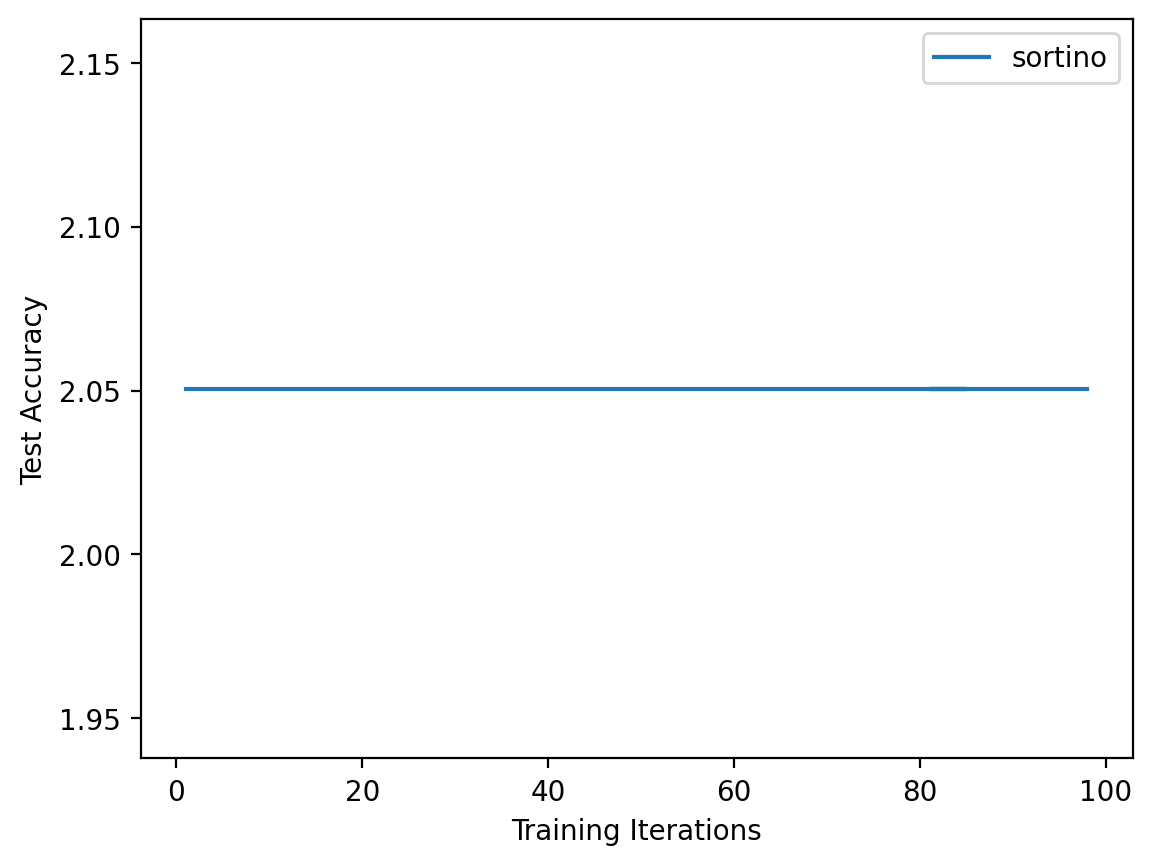

In [8]:
# Get the best trial result
best_result = results_grid.get_best_result(metric="sortino", mode="max")

# Print `path` where checkpoints are stored
print('Best result path:', best_result.path)

# Print the best trial `config` reported at the last iteration
# NOTE: This config is just what the trial ended up with at the last iteration.
# See the next section for replaying the entire history of configs.
print("Best final iteration hyperparameter config:\n", best_result.config)

# Plot the learning curve for the best trial
df = best_result.metrics_dataframe
# Deduplicate, since PBT might introduce duplicate data
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "sortino")
plt.xlabel("Training Iterations")
plt.ylabel("Test Accuracy")
plt.show()

In [9]:
checkpoint_dir = "C:/ray_results/pbt_test/train_attention_add38_00000_0_lr=0.3682,momentum=0.9704_2024-04-03_15-40-06"
checkpoint_dict = torch.load(checkpoint_dir + "/checkpoint_000009/checkpoint.pt")
model = AttentionModel(n_features=3, lookback=16, h_size=128, v_size=64)
model.load_state_dict(checkpoint_dict["model_state_dict"])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/ray_results/pbt_test/train_attention_add38_00000_0_lr=0.3682,momentum=0.9704_2024-04-03_15-40-06/checkpoint_000009/checkpoint.pt'

In [ ]:
val_inputs = torch.tensor(X_bck, dtype=torch.float32)  # Ensure validation inputs are tensors and on the same device as the model
val_outputs = model(val_inputs).detach().cpu().numpy()
BT_report = bt.classifier_backtest(df,
                        val_outputs,
                        y_bck_datetime,
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)

KeyError: 'close'

In [ ]:
1. - tune.loguniform(0.0001, 1)

TypeError: unsupported operand type(s) for -: 'float' and 'Float'